# Packages


In [1]:
import json
import argparse
import sys,os
import random
import datetime
import pandas as pd
import numpy as np
from math import factorial
import multiprocessing as mp
import matplotlib.pyplot as plt
from matplotlib import font_manager
import csv
from pySODM.models.base import ODEModel
from pySODM.optimization import pso, nelder_mead
from pySODM.optimization.utils import add_poisson_noise, assign_theta, variance_analysis
from pySODM.optimization.mcmc import perturbate_theta, run_EnsembleSampler, emcee_sampler_to_dictionary
from pySODM.optimization.objective_functions import log_posterior_probability, log_prior_uniform, ll_gaussian
from covid19_DTM.data.sciensano import get_sciensano_COVID19_data
from functools import lru_cache
from decimal import Decimal
import xarray as xar
import math

def get_lower(x):
    return np.quantile(x,0.025)
def get_upper(x):
    return np.quantile(x,0.975)

# data and samples


In [2]:
abs_dir = os.getcwd()
rel_dir = '../../data/PHM/interim/UZG'

# Postponed healthcare data
file_name = '2020_2021_normalized.csv'
types_dict = {'APR_MDC_key': str}
# mean data
hospitalizations_normalized = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict,parse_dates=True)['mean']
# hospitalizations_normalized = hospitalizations_normalized.reorder_levels(['date','APR_MDC_key'])
hospitalizations_normalized=hospitalizations_normalized.sort_index()
hospitalizations_normalized=hospitalizations_normalized.reindex(hospitalizations_normalized.index.rename('MDC',level=0))

MDC_keys = sorted(hospitalizations_normalized.index.get_level_values('MDC').unique().values)
dates = hospitalizations_normalized.index.get_level_values('date').unique().values

# lower and upper quantiles
hospitalizations_normalized_quantiles = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict,parse_dates=True).loc[(slice(None), slice(None)), ('q0.025','q0.975')]
# hospitalizations_normalized_quantiles = hospitalizations_normalized_quantiles.reorder_levels(['date','APR_MDC_key'])
hospitalizations_normalized_quantiles=hospitalizations_normalized_quantiles.sort_index()
hospitalizations_normalized_quantiles=hospitalizations_normalized_quantiles.reindex(hospitalizations_normalized_quantiles.index.rename('MDC',level=0))

file_name = 'MZG_2016_2021.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2,3],dtype=types_dict).squeeze()
hospitalizations = hospitalizations.groupby(['APR_MDC_key','date']).sum()
hospitalizations.index = hospitalizations.index.set_levels([hospitalizations.index.levels[0], pd.to_datetime(hospitalizations.index.levels[1])])
# hospitalizations = hospitalizations.reorder_levels(['date','APR_MDC_key'])
hospitalizations=hospitalizations.sort_index()
hospitalizations=hospitalizations.reindex(hospitalizations.index.rename('MDC',level=0))

# COVID-19 data
covid_data, _ , _ , _ = get_sciensano_COVID19_data(update=False)
new_index = pd.MultiIndex.from_product([pd.to_datetime(hospitalizations.index.get_level_values('date').unique()),covid_data.index.get_level_values('NIS').unique()])
covid_data = covid_data.reindex(new_index,fill_value=0)
df_covid_H_in = covid_data['H_in'].loc[:,40000]
df_covid_H_tot = covid_data['H_tot'].loc[:,40000]
df_covid_dH = df_covid_H_tot.diff().fillna(0)

# hospitalisation baseline
file_name = 'MZG_baseline.csv'
types_dict = {'APR_MDC_key': str, 'week_number': int, 'day_number':int}
hospitalizations_baseline = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2,3],dtype=types_dict).squeeze()
hospitalizations_baseline_lower = hospitalizations_baseline.groupby(['APR_MDC_key','week_number','day_number']).apply(get_lower)
hospitalizations_baseline_upper = hospitalizations_baseline.groupby(['APR_MDC_key','week_number','day_number']).apply(get_upper)
hospitalizations_baseline = hospitalizations_baseline.groupby(['APR_MDC_key','week_number','day_number']).mean()
hospitalizations_baseline=hospitalizations_baseline.reindex(hospitalizations_baseline.index.rename('MDC',level=0))

# mean hospitalisation length
file_name = 'MZG_residence_times.csv'
types_dict = {'APR_MDC_key': str, 'age_group': str, 'stay_type':str}
residence_times = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2],dtype=types_dict).squeeze()
mean_residence_times = residence_times.groupby(by=['APR_MDC_key']).mean()
mean_residence_times['covid']=10

rel_dir = '../../data/PHM/interim/'
file_name = 'hospital_costs.csv'
hospital_costs = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0],na_values='/')

In [3]:
#rel_dir = '../../data/PHM/interim/UZG'
#file_name = 'MZG_2016_2021.csv'
#types_dict = {'APR_MDC_key': str}
#hospitalizations = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2,3],dtype=types_dict).squeeze()

In [4]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

multi_index = pd.MultiIndex.from_product([MDC_keys,dates])
baseline_in_date_form = pd.Series(index=multi_index,dtype='float')
lower_baseline_in_date_form = pd.Series(index=multi_index,dtype='float')
upper_baseline_in_date_form = pd.Series(index=multi_index,dtype='float')
for idx,(disease,date) in enumerate(multi_index):
    date = pd.to_datetime(date)
    baseline_in_date_form[idx] = hospitalizations_baseline.loc[(disease,date.isocalendar().week,date.isocalendar().weekday)]
    lower_baseline_in_date_form[idx] = hospitalizations_baseline_lower.loc[(disease,date.isocalendar().week,date.isocalendar().weekday)]
    upper_baseline_in_date_form[idx] = hospitalizations_baseline_upper.loc[(disease,date.isocalendar().week,date.isocalendar().weekday)]

window = 61
order = 4

hospitalizations_normalized_smooth = hospitalizations_normalized.copy()
hospitalizations_smooth = hospitalizations.copy()
hospitalizations_baseline_smooth = baseline_in_date_form.copy()
hospitalizations_baseline_lower_smooth = baseline_in_date_form.copy()
hospitalizations_baseline_upper_smooth = baseline_in_date_form.copy()
hospitalizations_normalized_lower_smooth = hospitalizations_normalized_quantiles['q0.025'].copy()
hospitalizations_normalized_upper_smooth = hospitalizations_normalized_quantiles['q0.975'].copy()
for MDC_key in MDC_keys:
    hospitalizations_normalized_smooth.loc[MDC_key] = savitzky_golay(hospitalizations_normalized.loc[MDC_key],window,order)
    hospitalizations_normalized_lower_smooth.loc[MDC_key] = savitzky_golay(hospitalizations_normalized_lower_smooth.loc[MDC_key],window,order)
    hospitalizations_normalized_upper_smooth.loc[MDC_key] = savitzky_golay(hospitalizations_normalized_upper_smooth.loc[MDC_key],window,order)
    
    hospitalizations_smooth.loc[MDC_key] = savitzky_golay(hospitalizations.loc[MDC_key],window,order)

    hospitalizations_baseline_smooth[MDC_key] = savitzky_golay(baseline_in_date_form[MDC_key],window,order)
    hospitalizations_baseline_lower_smooth[MDC_key] = savitzky_golay(lower_baseline_in_date_form[MDC_key],window,order)
    hospitalizations_baseline_upper_smooth[MDC_key] = savitzky_golay(upper_baseline_in_date_form[MDC_key],window,order)

In [3]:
abs_dir = os.getcwd()

In [5]:
rel_dir = '../../data/QALY_model/interim/postponed_healthcare/model_parameters'

# Load samples
file_names_first = ['queuing_model_SAMPLES_first.json',
                    'constrained_PI_SAMPLES_first.json',
                    'PI_SAMPLES_first.json']
file_names_second = ['queuing_model_SAMPLES_second.json',
                     'constrained_PI_SAMPLES_second.json',
                     'PI_SAMPLES_second.json']
sample_names = ['queuing_model','constrained_PI','PI']

samples = {'first_wave':{},'second_wave':{}}
for period,file_names in zip(samples.keys(),[file_names_first,file_names_second]):
    for file_name,sample_name in zip(file_names,sample_names):
        f = open(os.path.join(abs_dir,rel_dir,file_name))
        samples[period].update({sample_name:json.load(f)})

In [17]:
with open(os.path.join(abs_dir,rel_dir,'queuing_model_SAMPLES_second.json'), 'w') as fp:
    json.dump(sample, fp)

In [6]:
start_calibration_first = pd.to_datetime('2020-01-01')
end_calibration_first = pd.to_datetime('2020-08-01')
start_calibration_second = pd.to_datetime('2020-08-01')
end_calibration_second = pd.to_datetime('2021-03-01')
MDC_plot = ['03', '04', '05']

label_font = font_manager.FontProperties(family='CMU Sans Serif',
                                style='normal', 
                                size=10)
legend_font = font_manager.FontProperties(family='CMU Sans Serif',
                                style='normal', 
                                size=8)

result_folder = os.path.join(abs_dir,'../../results/PHM/analysis/')

# models and functions


## models

In [7]:
class Constrained_PI_Model(ODEModel):

    state_names = ['H_norm','E']
    parameter_names = ['covid_H','covid_dH','covid_capacity']
    parameter_stratified_names = ['Kp', 'Ki', 'alpha','epsilon']
    dimension_names = ['MDC']
    
    @staticmethod
    def integrate(t, H_norm, E, covid_H, covid_dH, Kp, Ki, alpha, epsilon, covid_capacity):

        error = 1-H_norm
        dE = error - epsilon*E
        u = np.where(covid_H <= covid_capacity, Kp * np.where(E<=0,error,0) + Ki * np.where(E>0,E,0), 0)
        dH_norm = -alpha*covid_dH + u

        return dH_norm, dE 
    
class PI_Model(ODEModel):
    
    state_names = ['H_norm','E']
    parameter_names = ['covid_H']
    parameter_stratified_names = ['Kp', 'Ki', 'alpha', 'epsilon']
    dimension_names = ['MDC']
    
    @staticmethod
    def integrate(t, H_norm, E, covid_H, Kp, Ki, alpha, epsilon):

        error = 1-H_norm
        dE = error - epsilon*E
        u = Kp*error + Ki*E
        dH_norm = -alpha*covid_H + u

        return dH_norm, dE 
    
class Queuing_model(ODEModel):

    state_names = ['W','H','H_adjusted','H_norm','R','NR','X']
    parameter_names = ['X_tot','f_UZG','covid_H','sigma_covid','post_processed_H']
    parameter_stratified_names = ['A','gamma','epsilon','sigma']
    dimension_names = ['MDC']
    
    @staticmethod
    def integrate(t, W, H, H_adjusted, H_norm, R, NR, X, X_tot, f_UZG, covid_H, sigma_covid, post_processed_H, A, gamma, epsilon, sigma):
        X_new = (X_tot-sigma_covid*covid_H-sum(H - (1/gamma*H))) * (sigma*(A+W))/sum(sigma*(A+W))

        W_to_H = np.where(W>X_new,X_new,W)
        W_to_NR = epsilon*(W-W_to_H)
        A_to_H = np.where(A>(X_new-W_to_H),(X_new-W_to_H),A)
        A_to_W = A-A_to_H
        
        dX = -X + X_new - W_to_H - A_to_H
        dW = A_to_W - W_to_H - W_to_NR
        dH = A_to_H + W_to_H - (1/gamma*H) 
        dR = (1/gamma*H)
        dNR = W_to_NR

        dH_adjusted = -H_adjusted + post_processed_H[0]
        dH_norm = -H_norm + post_processed_H[1]
        
        return dW, dH, dH_adjusted, dH_norm, dR, dNR, dX

## TDF

In [8]:
class get_A():
    def __init__(self, baseline, mean_residence_times):
        self.baseline = baseline
        self.mean_residence_times = mean_residence_times
        
    def A_wrapper_func(self, t, states, param):
        return self.__call__(t)
    
    @lru_cache()
    def __call__(self, t):

        A = (self.baseline.loc[(slice(None),t)]/self.mean_residence_times).values

        return A 
    
class H_post_processing():

    def __init__(self, baseline, MDC_sim):
        self.MDC = np.array(MDC_sim)
        self.baseline = baseline

    def H_post_processing_wrapper_func(self, t, states, param, covid_H):
        H = states['H']
        return self.__call__(t, H, covid_H)

    def __call__(self, t, H, covid_H):
        H_adjusted = np.where(self.MDC=='04',H+covid_H,H)
        H_norm = H_adjusted/self.baseline.loc[slice(None),t]
        return (H_adjusted,H_norm)
    
class get_covid_H():

    def __init__(self, use_covid_data, covid_data=None, baseline=None, hospitalizations=None):
        self.use_covid_data = use_covid_data
        if use_covid_data:
            self.covid_data = covid_data
        else:
            self.baseline_04 = baseline['04']
            self.hospitalizations_04 = hospitalizations.loc[(slice(None),'04')]

    def H_wrapper_func(self, t, states, param, f_UZG):
        return self.__call__(t, f_UZG)

    def __call__(self, t, f_UZG):
        if self.use_covid_data:
            t = pd.to_datetime(t).round(freq='D')
            try:
                covid_H = self.covid_data.loc[t]*f_UZG
            except:
                covid_H = 0

        else:
            covid_H = max(self.hospitalizations_04.loc[t] - self.baseline_04.loc[t],0)
        
        return covid_H 
    
class get_covid_dH():

    def __init__(self, data):
        self.data = data

    def dH_wrapper_func(self, t, states, param):
        return self.__call__(t)

    @lru_cache
    def __call__(self, t):
        t = pd.to_datetime(t).round(freq='D')
        try:
            covid_dH = self.data.loc[t]
        except:
            covid_dH = 0

        return covid_dH

## init models

In [9]:
def init_models(start_date):
    # init queuing model
    gamma =  mean_residence_times.loc[MDC_keys].values
    epsilon = np.ones(len(MDC_keys))*0.1
    sigma = np.ones(len(MDC_keys))
    sigma_covid = 5

    f_UZG = 0.13
    X_tot = 1049

    start_date_string = start_date.strftime('%Y-%m-%d')
    covid_H = df_covid_H_tot.loc[start_date_string]*f_UZG
    H_init = hospitalizations_baseline_smooth.loc[(MDC_keys,start_date)].values
    H_init_normalized = (H_init/hospitalizations_baseline_smooth.loc[((MDC_keys,start_date))]).values
    A = H_init/mean_residence_times.loc[MDC_keys]

    params={'A':A,'covid_H':0,'sigma_covid':sigma_covid,'post_processed_H':(H_init,H_init_normalized),'X_tot':X_tot, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma,'f_UZG':f_UZG}

    init_states = {'H':H_init,'H_norm':np.ones(len(MDC_keys)), 'H_adjusted':H_init}
    coordinates={'MDC':MDC_keys}

    daily_hospitalizations_func = get_A(hospitalizations_baseline_smooth,mean_residence_times.loc[MDC_keys]).A_wrapper_func
    covid_H_func = get_covid_H(True,df_covid_H_tot,hospitalizations_baseline_smooth,hospitalizations).H_wrapper_func
    post_processing_H_func = H_post_processing(hospitalizations_baseline_smooth,MDC_keys).H_post_processing_wrapper_func

    # Initialize model
    queuing_model = Queuing_model(init_states,params,coordinates,
                            time_dependent_parameters={'A': daily_hospitalizations_func,'covid_H':covid_H_func,'post_processed_H':post_processing_H_func})
    
    n = len(MDC_keys) 
    # init constrained PI model
    alpha = 0.0005*np.ones(n)
    epsilon = 0.05*np.ones(n)

    Kp = 0.05*np.ones(n)
    Ki = 0.003*np.ones(n)

    covid_capacity = 20

    start_date_string = start_date.strftime('%Y-%m-%d')
    covid_H = df_covid_H_tot.loc[start_date_string]
    covid_dH = df_covid_dH.loc[start_date_string]
    params={'covid_H':covid_H,'covid_dH':covid_dH,'epsilon':epsilon, 'alpha':alpha, 'Kp':Kp,'Ki':Ki,'covid_capacity':covid_capacity,'f_UZG':1}

    init_states = {'H_norm':np.ones(n)}
    coordinates={'MDC':MDC_keys}

    covid_H_func = get_covid_H(True,df_covid_H_tot,hospitalizations_baseline_smooth,hospitalizations).H_wrapper_func
    dH_function = get_covid_dH(df_covid_dH).dH_wrapper_func

    constrained_PI_model = Constrained_PI_Model(init_states,params,coordinates,
                            time_dependent_parameters={'covid_H':covid_H_func,'covid_dH':dH_function})
       
    # init PI model
    alpha = 0.00003*np.ones(n)
    epsilon = 0.03*np.ones(n)

    Kp = 0.01*np.ones(n)
    Ki = 0.005*np.ones(n)

    start_date_string = start_date.strftime('%Y-%m-%d')
    covid_H = df_covid_H_tot.loc[start_date_string]

    params={'covid_H':covid_H,'epsilon':epsilon, 'alpha':alpha, 'Kp':Kp,'Ki':Ki,'f_UZG':1}

    init_states = {'H_norm':np.ones(n)}
    coordinates={'MDC':MDC_keys}

    covid_H_func = get_covid_H(True,df_covid_H_tot,hospitalizations_baseline_smooth,hospitalizations).H_wrapper_func

    PI_model = PI_Model(init_states,params,coordinates,
                            time_dependent_parameters={'covid_H':covid_H_func})
    
    return queuing_model,constrained_PI_model,PI_model

# Simulations

In [10]:
def draw_fcn_PI(param_dict, samples_dict):
    pars = list(samples_dict.values())[0]['parameters']
    param_dict_updates = {}            
    for param in pars:
        param_dict_updates.update({param:np.array([])})

    for MDC_key in list(samples_dict.keys()):
        samples_for_MDC = samples_dict[MDC_key]
        idx = random.randint(0,len(samples_for_MDC[pars[0]][0])-1)
        for param in pars:
            param_dict_updates[param] = np.append(param_dict_updates[param],samples_for_MDC[param][0][idx])
    
    param_dict.update(param_dict_updates)
    return param_dict

In [11]:
def draw_fcn(param_dict, samples_dict):
    pars = samples_dict['parameters']

    if hasattr(samples_dict[pars[0]][0],'__iter__'):
        idx = random.randint(0,len(samples_dict[pars[0]][0])-1)
    else:
        idx = random.randint(0,len(samples_dict[pars[0]])-1)
    
    for param in pars:
        if hasattr(samples_dict[param][0],'__iter__'):
            par_array = np.array([])
            for samples in samples_dict[param]:
                par_array = np.append(par_array,samples[idx])
            param_dict.update({param:par_array})
        else:
            param_dict.update({param:samples_dict[param][idx]})
    return param_dict

In [12]:
def MAE(data,outs,MDC_key):
    AE = 0
    for out in outs:
        start_date = out.date[0].values
        end_date = out.date[-1].values
        date_range = pd.date_range(start_date,end_date)

        y_data = data.loc[(MDC_key,date_range)]
        y_model = out['H_norm'].sel(date=date_range,MDC=MDC_key).mean('draws')
        AE += sum(abs(y_model-y_data))
    
    start_date = outs[0].date[0].values
    end_date = outs[-1].date[-1].values
    date_range = pd.date_range(start_date,end_date)
    return AE/len(date_range)

In [87]:
def plot_model_outputs(plot_name,outs,plot_start,plot_end,start_calibration,end_calibration,MDC_plot):
    plot_time = pd.date_range(plot_start,plot_end)

    box_props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    fig,axs = plt.subplots(len(MDC_plot),3,sharex=True,sharey='row',figsize=(6,1.3*len(MDC_plot)))
    axs[0,0].set_title('Queuing model',font=label_font)
    axs[0,1].set_title('Constrained PI Model',font=label_font)
    axs[0,2].set_title('PI Model',font=label_font)

    for i,MDC_key in enumerate(MDC_plot):
        axs[i,0].set_ylabel(MDC_key,font=label_font)
        for j,out in enumerate(outs):

            mean_fit = out['H_norm'].sel(date=plot_time,MDC=MDC_key).mean('draws')
            lower_fit = out['H_norm'].sel(date=plot_time,MDC=MDC_key).quantile(dim='draws', q=0.025)
            upper_fit = out['H_norm'].sel(date=plot_time,MDC=MDC_key).quantile(dim='draws', q=0.975)
            mae = MAE(hospitalizations_normalized_smooth,[out],MDC_key)
            axs[i,j].text(0.05, 0.95, f'MAE={mae:.3f}', transform=axs[i,j].transAxes, fontsize=8,verticalalignment='top', bbox=box_props, font=legend_font)

            # data
            axs[i,j].plot(plot_time,hospitalizations_normalized_smooth.loc[MDC_key,plot_time], label='Filtered data', alpha=0.7,linewidth=1)
            axs[i,j].fill_between(plot_time,hospitalizations_normalized_lower_smooth.loc[MDC_key,plot_time],
                                            hospitalizations_normalized_upper_smooth.loc[MDC_key,plot_time], alpha=0.2, label='95% CI on data')
            # sim
            axs[i,j].plot(plot_time,mean_fit, color='black', label='Model output',linewidth=1,alpha=0.7)
            axs[i,j].fill_between(plot_time,lower_fit,upper_fit,color='black', alpha=0.2, label='95% CI on model output')
            
            # fancy plot
            axs[i,j].set_xticks(pd.date_range(plot_start+pd.Timedelta('60D'),plot_end-pd.Timedelta('60D'),periods=2))
            axs[i,j].grid(False)
            axs[i,j].tick_params(axis='both', which='major', labelsize=8)
            axs[i,j].tick_params(axis='both', which='minor', labelsize=8)
            axs[i,j].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5)
            if hasattr(start_calibration,'__iter__'):
                for start in start_calibration:
                    axs[i,j].axvline(x = start, color = 'gray', linestyle = 'dashed', alpha=0.5)
            else:
                axs[i,j].axvline(x = start_calibration, color = 'gray', linestyle = 'dashed', alpha=0.5) 
            if hasattr(end_calibration,'__iter__'):
                for end in end_calibration:
                    axs[i,j].axvline(x = end, color = 'gray', linestyle = 'dashed', alpha=0.5)
            else:  
                axs[i,j].axvline(x = end_calibration, color = 'gray', linestyle = 'dashed', alpha=0.5) 

    handles, plot_labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles=handles,labels=plot_labels,bbox_to_anchor =(0.5,-0.04), loc='lower center',fancybox=False, shadow=False,ncol=5, prop=legend_font)

    fig.tight_layout()
    fig.savefig(os.path.join(result_folder,plot_name),dpi=600,bbox_inches='tight')

In [52]:
N = 20
processes = int(os.getenv('SLURM_CPUS_ON_NODE', mp.cpu_count()/2))

In [53]:
# simulate and plot first wave
start_date = start_calibration_first
end_date = end_calibration_second

queuing_model,constrained_PI_model,PI_model = init_models(start_date)
out_queuing = queuing_model.sim([start_date,end_date],N=N, samples=samples['first_wave']['queuing_model'], draw_function=draw_fcn,tau=1)
out_constrained_PI = constrained_PI_model.sim([start_date,end_date], N=N, samples=samples['first_wave']['constrained_PI'], draw_function=draw_fcn,method='LSODA')
out_PI = PI_model.sim([start_date,end_date], N=N, samples=samples['first_wave']['PI'], draw_function=draw_fcn,method='LSODA')
outs_first = [out_queuing,out_constrained_PI,out_PI]

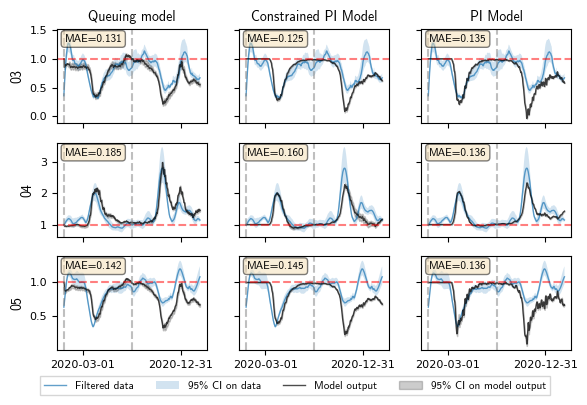

In [88]:
start_date = start_calibration_first
end_date = end_calibration_second
plot_model_outputs('postponed_healthcare_calibrations_first_wave.pdf',outs_first,start_date,end_date,start_calibration_first,end_calibration_first,MDC_plot)

In [55]:
# simulate and plot second wave
start_date = start_calibration_second
end_date = pd.to_datetime(dates[-1])

queuing_model,constrained_PI_model,PI_model = init_models(start_date)
out_queuing = queuing_model.sim([start_date,end_date],N=N, samples=samples['second_wave']['queuing_model'], draw_function=draw_fcn,tau=1)
out_constrained_PI = constrained_PI_model.sim([start_date,end_date], N=N, samples=samples['second_wave']['constrained_PI'], draw_function=draw_fcn,method='LSODA')
out_PI = PI_model.sim([start_date,end_date], N=N, samples=samples['second_wave']['PI'], draw_function=draw_fcn,method='LSODA')
outs_second = [out_queuing,out_constrained_PI,out_PI]

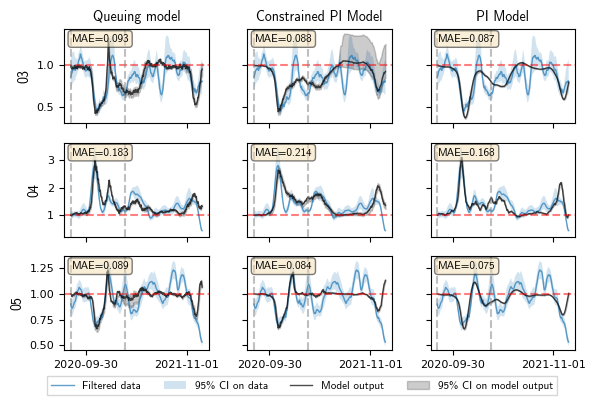

In [89]:
start_date = start_calibration_second
end_date = pd.to_datetime(dates[-1])
plot_model_outputs('postponed_healthcare_calibrations_second_wave.pdf',outs_second,start_date,end_date,start_calibration_second,end_calibration_second,MDC_plot)

In [19]:
outs_first_trimmed = [out.sel(date=pd.date_range(start_calibration_first,end_calibration_first-pd.Timedelta('1D'))) for out in outs_first]

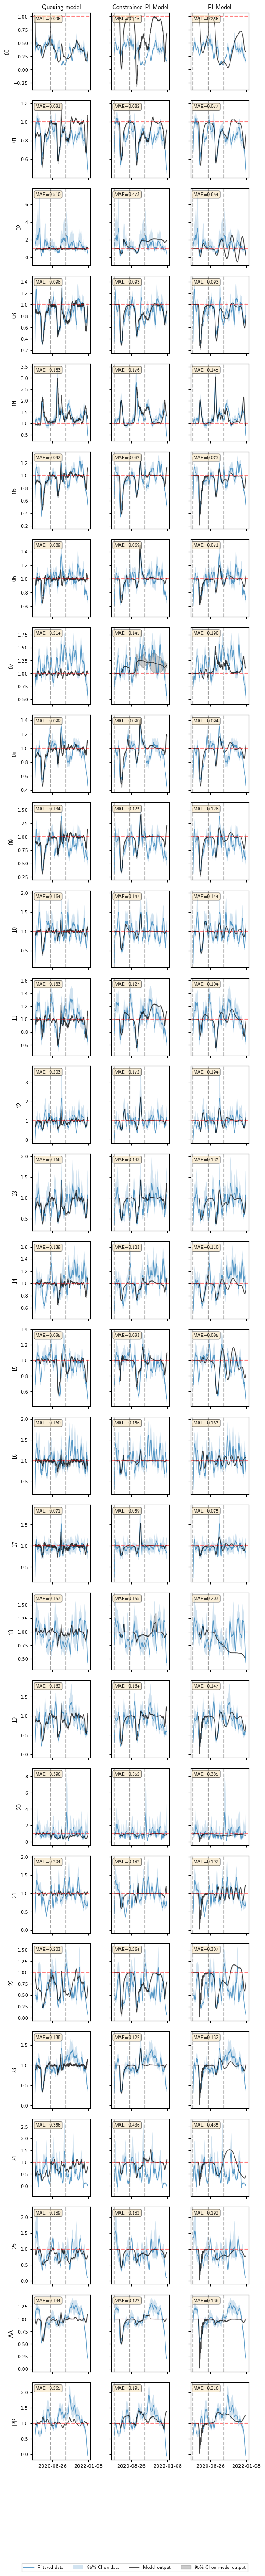

In [20]:
start_date = start_calibration_first
end_date = pd.to_datetime(dates[-1])
outs_full = [xar.concat([out_first,out_second],dim='date') for out_first,out_second in zip(outs_first_trimmed,outs_second)]
plot_model_outputs('postponed_healthcare_calibrations_second_wave_all_MDC_full_period.pdf',outs_full,start_date,end_date,[start_calibration_first,start_calibration_second],[end_calibration_first,end_calibration_second],MDC_keys)

# Parameters table

In [21]:
def extract_parameters_for_MDC(MDC_key,samples_dict):
    MDC_idx = MDC_keys.index(MDC_key)

    pars = samples_dict['parameters']
    
    calibrated_parameters = []
    
    for param in pars:
        if hasattr(samples_dict[param][0],'__iter__'):
            samples = samples_dict[param][MDC_idx]
        else:
            samples = samples_dict[param]
        mean = np.mean(samples)
        lower = np.quantile(samples,0.025)
        upper = np.quantile(samples,0.975)

        calibrated_parameters.append(f'{mean:.2E}\n({lower:.2E};{upper:.2E})')
    return calibrated_parameters
    

In [22]:
models = ['queuing_model','constrained_PI','PI']
MAEs = pd.DataFrame(index=MDC_keys,columns=models)
for model,outs in zip(models,zip(outs_first_trimmed,outs_second)):
    model_fit_summary = {}

    # calibrated parameters per MDC
    for out, period in zip(outs,['first_wave','second_wave']):
        samples_dict = samples[period][model]
        parameters = samples_dict['parameters']

        start_calibration = pd.to_datetime(samples_dict['start_calibration'])
        end_calibration = pd.to_datetime(samples_dict['end_calibration'])
        calibration_period = pd.date_range(start_calibration,end_calibration-pd.Timedelta('1D'))

        model_fit = pd.DataFrame(index=MDC_keys,columns=parameters+['MAE'])
        for MDC_key in MDC_keys: 
            model_fit.loc[MDC_key][parameters] = extract_parameters_for_MDC(MDC_key,samples_dict)
            mae = MAE(hospitalizations_normalized_smooth.loc[MDC_key,calibration_period],
                      [out.sel(date=calibration_period)],MDC_key)     
            model_fit.loc[MDC_key]['MAE'] = f'{mae:.3f}'
        model_fit_summary[period]=model_fit.drop(columns=['MAE'])
        model_fit.to_csv(os.path.join(result_folder,model+'_'+period+'_fit.csv'))

    # overall MAE per MDC
    for MDC_key in MDC_keys:
        mae = MAE(hospitalizations_normalized_smooth,outs,MDC_key)     
        MAEs.loc[MDC_key][model] = f'{mae:.3f}'
    model_fit_summary['MAE']=MAEs[model]

    # save result in dataframe, csv
    model_fit_summary = pd.concat(model_fit_summary, axis=1)
    model_fit_summary.to_csv(os.path.join(result_folder,model+'_fit_summary.csv')) 

MAEs.to_csv(os.path.join(result_folder,'MAE.csv'))

# QALY calculation

In [23]:
models = ['queuing_model','constrained_PI','PI']
multi_index = pd.MultiIndex.from_product([MDC_keys+['total','total (no negatives)'],models+['data']],names=['disease_group','model'])
reductions = pd.DataFrame(index=multi_index,columns=['mean','lower','upper'])
QALYs = pd.DataFrame(index=multi_index,columns=['mean','lower','upper'])
result_table = pd.DataFrame(index=multi_index,columns=['reduction','QALY'])

for model,out in zip(models,outs_full):
    delta_t = pd.Timedelta((out.date[-1]-out.date[0]).values)/pd.Timedelta('1D')
    date_range = pd.date_range(out.date[0].values,out.date[-1].values)

    mean_total_QALY_loss,lower_total_QALY_loss,upper_total_QALY_loss = 0,0,0
    mean_total_QALY_loss_noN,lower_total_QALY_loss_noN,upper_total_QALY_loss_noN = 0,0,0
    mean_total_difference,lower_total_difference,upper_total_difference = 0,0,0
    mean_total_difference_noN,lower_total_difference_noN,upper_total_difference_noN = 0,0,0
    total_reference, total_reference_noN = 0,0
    
    for MDC_key in MDC_keys:
        # MDC specific
        reference = sum(hospitalizations_baseline_smooth.loc[(MDC_key,date_range)].values/mean_residence_times[MDC_key])
        #if model == 'queuing_model':
        #    mean_difference += out['NR'].sel(MDC=MDC_key).mean('draws').values[-1]
        #    lower_difference += out['NR'].sel(MDC=MDC_key).quantile(dim='draws', q=0.025).values[-1]
        #    upper_difference += out['NR'].sel(MDC=MDC_key).quantile(dim='draws', q=0.975).values[-1]
        #else:
        mean_difference  = reference-sum(hospitalizations_baseline_smooth.loc[(MDC_key,date_range)].values*out['H_norm'].sel(MDC=MDC_key).mean('draws').values/mean_residence_times[MDC_key])
        upper_difference = reference-sum(hospitalizations_baseline_smooth.loc[(MDC_key,date_range)].values*out['H_norm'].sel(MDC=MDC_key).quantile(dim='draws', q=0.025).values/mean_residence_times[MDC_key])
        lower_difference = reference-sum(hospitalizations_baseline_smooth.loc[(MDC_key,date_range)].values*out['H_norm'].sel(MDC=MDC_key).quantile(dim='draws', q=0.975).values/mean_residence_times[MDC_key])

        mean_r = mean_difference/reference
        lower_r = lower_difference/reference
        upper_r = upper_difference/reference

        delta_t = pd.Timedelta((outs[1].date[-1]-outs[0].date[0]).values)/pd.Timedelta('1D')
        mean_QALY = delta_t/365*mean_r*hospital_costs.loc[MDC_key]['yearly_QALYs_mean']
        lower_QALY = delta_t/365*lower_r*hospital_costs.loc[MDC_key]['yearly_QALYs_lower']
        upper_QALY = delta_t/365*upper_r*hospital_costs.loc[MDC_key]['yearly_QALYs_upper']

        # totals
        total_reference += reference

        mean_total_difference += mean_difference
        lower_total_difference += lower_difference
        upper_total_difference += upper_difference

        if not math.isnan(mean_QALY):
            mean_total_QALY_loss += mean_QALY
        if not math.isnan(lower_QALY):
            lower_total_QALY_loss += lower_QALY
        if not math.isnan(upper_QALY):
            upper_total_QALY_loss += upper_QALY

        if mean_difference > 0:
            total_reference_noN += reference

            mean_total_difference_noN += mean_difference
            lower_total_difference_noN += lower_difference
            upper_total_difference_noN += upper_difference

            if not math.isnan(mean_QALY):
                mean_total_QALY_loss_noN += mean_QALY
            if not math.isnan(lower_QALY):
                lower_total_QALY_loss_noN += lower_QALY
            if not math.isnan(upper_QALY):
                upper_total_QALY_loss_noN += upper_QALY

        # writing data
        reductions.loc[(MDC_key,model)]['mean'] = mean_r 
        reductions.loc[(MDC_key,model)]['lower'] = lower_r 
        reductions.loc[(MDC_key,model)]['upper'] = upper_r
        result_table.loc[(MDC_key,model)]['reduction'] = f'{mean_r*100:.2f} ({lower_r*100:.2f};{upper_r*100:.2f})'

        QALYs.loc[(MDC_key,model)]['mean'] = mean_QALY 
        QALYs.loc[(MDC_key,model)]['lower'] = lower_QALY 
        QALYs.loc[(MDC_key,model)]['upper'] = upper_QALY
        result_table.loc[(MDC_key,model)]['QALY'] = f'{mean_QALY:.0f} ({lower_QALY:.0f};{upper_QALY:.0f})'

    # calculate total reduction
    for (mean_difference,lower_difference, upper_difference),(mean_QALY_loss,lower_QALY_loss, upper_QALY_loss), reference, total in zip(((mean_total_difference,lower_total_difference,upper_total_difference),
                                                                                                                                         (mean_total_difference_noN,lower_total_difference_noN,upper_total_difference_noN)),
                                                                                                                                         ((mean_total_QALY_loss,lower_total_QALY_loss,upper_total_QALY_loss),
                                                                                                                                         (mean_total_QALY_loss_noN,lower_total_QALY_loss_noN,upper_total_QALY_loss_noN)),
                                                                                                                                         (total_reference,total_reference_noN),
                                                                                                                                         ('total','total (no negatives)')):
        mean_r = mean_difference/reference
        lower_r = lower_difference/reference
        upper_r = upper_difference/reference

        reductions.loc[(total,model)]['mean'] = mean_r 
        reductions.loc[(total,model)]['lower'] = lower_r 
        reductions.loc[(total,model)]['upper'] = upper_r
        result_table.loc[(total,model)]['reduction'] = f'{mean_r*100:.2f} ({lower_r*100:.2f};{upper_r*100:.2f})'

        QALYs.loc[(total,model)]['mean'] = mean_QALY_loss 
        QALYs.loc[(total,model)]['lower'] = lower_QALY_loss 
        QALYs.loc[(total,model)]['upper'] = upper_QALY_loss
        result_table.loc[(total,model)]['QALY'] = f'{mean_QALY_loss:.0f} ({lower_QALY_loss:.0f};{upper_QALY_loss:.0f})'

# data
date_range = pd.date_range(dates[0],dates[-1])
mean_total_QALY_loss,lower_total_QALY_loss,upper_total_QALY_loss = 0,0,0
mean_total_QALY_loss_noN,lower_total_QALY_loss_noN,upper_total_QALY_loss_noN = 0,0,0
mean_total_difference, mean_total_difference_noN = 0,0
mean_total_reference,lower_total_reference,upper_total_reference = 0,0,0 
mean_total_reference_noN,lower_total_reference_noN,upper_total_reference_noN = 0,0,0 
for MDC_key in MDC_keys:
    # MDC specific
    mean_reference = sum(hospitalizations_baseline_smooth.loc[(MDC_key,date_range)].values/mean_residence_times[MDC_key])
    lower_reference = sum(hospitalizations_baseline_lower_smooth.loc[(MDC_key,date_range)].values/mean_residence_times[MDC_key])
    upper_reference = sum(hospitalizations_baseline_upper_smooth.loc[(MDC_key,date_range)].values/mean_residence_times[MDC_key])

    mean_difference = mean_reference-sum(hospitalizations_smooth.loc[(MDC_key,date_range)]/mean_residence_times[MDC_key])
    
    mean_r = mean_difference/mean_reference
    lower_r = mean_difference/upper_reference
    upper_r = mean_difference/lower_reference

    delta_t = pd.Timedelta((dates[-1]-dates[0]))/pd.Timedelta('1D')
    mean_QALY = delta_t/365*mean_r*hospital_costs.loc[MDC_key]['yearly_QALYs_mean']
    lower_QALY = delta_t/365*lower_r*hospital_costs.loc[MDC_key]['yearly_QALYs_lower']
    upper_QALY = delta_t/365*upper_r*hospital_costs.loc[MDC_key]['yearly_QALYs_upper']
    
    # writing data
    reductions.loc[(MDC_key,'data')]['mean'] = mean_r 
    reductions.loc[(MDC_key,'data')]['lower'] = lower_r 
    reductions.loc[(MDC_key,'data')]['upper'] = upper_r
    result_table.loc[(MDC_key,'data')]['reduction'] = f'{mean_r*100:.2f} ({lower_r*100:.2f};{upper_r*100:.2f})'

    QALYs.loc[(MDC_key,'data')]['mean'] = mean_QALY 
    QALYs.loc[(MDC_key,'data')]['lower'] = lower_QALY 
    QALYs.loc[(MDC_key,'data')]['upper'] = upper_QALY
    result_table.loc[(MDC_key,'data')]['QALY'] = f'{mean_QALY:.0f} ({lower_QALY:.0f};{upper_QALY:.0f})'

    # totals
    mean_total_reference += mean_reference
    lower_total_reference += lower_reference
    upper_total_reference += upper_reference

    mean_total_difference += mean_difference

    if not math.isnan(mean_QALY):
        mean_total_QALY_loss += mean_QALY
    if not math.isnan(lower_QALY):
        lower_total_QALY_loss += lower_QALY
    if not math.isnan(upper_QALY):
        upper_total_QALY_loss += upper_QALY
    
    if mean_difference > 0:
        mean_total_reference_noN += mean_reference
        lower_total_reference_noN += lower_reference
        upper_total_reference_noN += upper_reference

        mean_total_difference_noN += mean_difference

        if not math.isnan(mean_QALY):
            mean_total_QALY_loss_noN += mean_QALY
        if not math.isnan(lower_QALY):
            lower_total_QALY_loss_noN += lower_QALY
        if not math.isnan(upper_QALY):
            upper_total_QALY_loss_noN += upper_QALY 

# calculate total reduction
for (mean_reference,lower_reference, upper_reference),(mean_QALY_loss,lower_QALY_loss, upper_QALY_loss), difference, total in zip(((mean_total_reference,lower_total_reference,upper_total_reference),
                                                                                                                                        (mean_total_reference_noN,lower_total_reference_noN,upper_total_reference_noN)),
                                                                                                                                        ((mean_total_QALY_loss,lower_total_QALY_loss,upper_total_QALY_loss),
                                                                                                                                        (mean_total_QALY_loss_noN,lower_total_QALY_loss_noN,upper_total_QALY_loss_noN)),
                                                                                                                                        (mean_total_difference,mean_total_difference_noN),
                                                                                                                                        ('total','total (no negatives)')):
    mean_r = difference/mean_reference
    lower_r = difference/lower_reference
    upper_r = difference/upper_reference

    reductions.loc[(total,'data')]['mean'] = mean_r 
    reductions.loc[(total,'data')]['lower'] = lower_r 
    reductions.loc[(total,'data')]['upper'] = upper_r
    result_table.loc[(total,'data')]['reduction'] = f'{mean_r*100:.2f} ({lower_r*100:.2f};{upper_r*100:.2f})'

    print(total)
    QALYs.loc[(total,'data')]['mean'] = mean_QALY_loss 
    QALYs.loc[(total,'data')]['lower'] = lower_QALY_loss 
    QALYs.loc[(total,'data')]['upper'] = upper_QALY_loss
    result_table.loc[(total,'data')]['QALY'] = f'{mean_QALY_loss:.0f} ({lower_QALY_loss:.0f};{upper_QALY_loss:.0f})'
    
reductions.to_csv(os.path.join(result_folder,'hospitalization_reductions.csv'))
QALYs.to_csv(os.path.join(result_folder,'postponed_healthcare_QALY_loss.csv'))
result_table.to_csv(os.path.join(result_folder,'postponed_healthcare_summary.csv'))

total
total (no negatives)


In [24]:
QALYs

mean          lower  \
disease_group        model                                          
00                   queuing_model     42713.12412   32261.299776   
                     constrained_PI   19500.545392   14441.690273   
                     PI               31690.676007   24062.894872   
                     data             43831.791439    28904.23687   
01                   queuing_model    14664.000831    8923.109797   
...                                            ...            ...   
total                data             94976.173754   62072.613832   
total (no negatives) queuing_model   134277.898857   92180.337696   
                     constrained_PI   82943.590029   55178.761016   
                     PI              122463.907954   86866.599335   
                     data            162332.723023  102629.697029   

                                             upper  
disease_group        model                          
00                   queuing_model    61849.977087  
                     constrained_PI   28777.177597  
                     PI               45650.602126  
                     data             74951.084578  
01                   queuing_model    36397.373148  
...                                            ...  
total                data            188634.736609  
total (no negatives) queuing_model   249480.676702  
                     constrained_PI   165571.61194  
                     PI               225205.48202  
                     data            338159.844345  

[120 rows x 3 columns]

In [25]:
from cycler import cycler
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))
#ax.set_prop_cycle(line_cycler)

In [26]:
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1.0, len(hospital_costs.index.drop('Respiratory system, eyes and ears'))))

KeyError: "['Respiratory system, eyes and ears'] not found in axis"

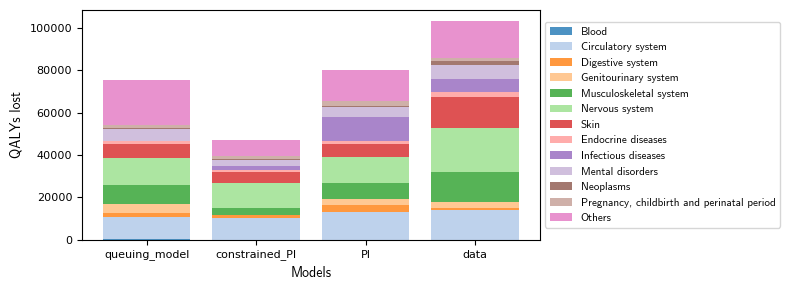

In [ ]:
bottom = np.zeros(len(models)+1)
fig, ax = plt.subplots(figsize=(8,3))
for MDC_key,color in zip(hospital_costs.index.drop('Respiratory system, eyes and ears'),cmap.colors):
    y = QALYs['mean'].loc[MDC_key].values
    ax.bar(models+['data'],y, alpha=0.8,bottom=bottom,label=MDC_key,color=color)
    bottom = bottom+y
ax.grid(False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop=legend_font)
ax.set_ylabel('QALYs lost',font=label_font)
ax.set_xlabel('Models',font=label_font)
ax.tick_params(axis='both', which='major', labelsize=8)
fig.tight_layout()
#fig.savefig(os.path.join(result_folder,f'QALY_losses_per_age_group_{scenario}.png'), dpi=600,bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(4,figsize=(10,10),sharex=True)
axs=axs.reshape(-1)
for ax, model in zip(axs,['data']+models):
    QALYs_plot = QALYs['mean'].loc[(slice(None),model)].drop(['total','Respiratory system, eyes and ears'])
    ax.stackplot(simtime,np.transpose(out[QALYs].mean(dim="draws").sum(dim='doses').values),linewidth=3, labels=age_group, colors=Palette, alpha=0.8)
    ax.set_title(title,fontsize=20)
    ax.set_ylabel('lost QALYs')
    ax = _apply_tick_locator(ax) 
    ax.grid(False)
    axs[0].legend(fancybox=True, frameon=True, framealpha=1, fontsize=15,title='Age Group', loc="upper left", bbox_to_anchor=(1,1)) 

plt.subplots_adjust(hspace=0.5)
fig.savefig(os.path.join(abs_dir,result_folder,f'QALY_losses_per_age_group_{scenario}.png'), dpi=600)

In [ ]:
QALYs['mean'].loc[(slice(None),'data')].drop(['total','Respiratory system, eyes and ears'])

In [ ]:
QALYs['mean'].loc[(slice(None),'data')].drop(['total','Respiratory system, eyes and ears'])

disease_group
Blood                                            33.959962
Circulatory system                            13842.479935
Digestive system                                1156.55341
Genitourinary system                           2782.487758
Musculoskeletal system                        14072.347508
Nervous system                                 21170.03112
Skin                                          14595.265807
Endocrine diseases                             2388.384942
Infectious diseases                            5797.515114
Mental disorders                               6711.173058
Neoplasms                                      1909.488763
Pregnancy, childbirth and perinatal period     1281.278227
Others                                        17672.136758
Name: mean, dtype: object

# Pre-COVID

In [ ]:
start_plot = pd.to_datetime('2019-01-01')
end_plot = pd.to_datetime('2020-01-01')
plot_time = pd.date_range(start_plot,end_plot)
queuing_model = init_queuing_model(start_plot,end_plot)

N = 2
out = queuing_model.sim([start_plot,end_plot],N=N, samples=samples_dict_queuing, draw_function=draw_fcn_queuing,tau=1)

NameError: name 'init_queuing_model' is not defined

In [ ]:
multi_index = pd.MultiIndex.from_product([MDC_keys,plot_time])
baseline_in_date_form = pd.Series(index=multi_index,dtype='float')
for idx,(disease,date) in enumerate(multi_index):
    baseline_in_date_form[idx] = hospitalization_baseline.loc[(disease,date.isocalendar().week,date.isocalendar().weekday)]

models = ['Queuing_model','Constrained_PI_Model','PI_Model']
outs = [out_queuing,out_constrained_PI,out_PI]
outs = [out_queuing]
index = pd.MultiIndex.from_product([MDC_keys,['mean','lower','upper']])
NR_table = pd.DataFrame(index=index,columns=models,dtype='float')
for MDC_key in MDC_keys:
    for out, model in zip(outs,models):
        if model == 'Queuing_model':
            mean = float(out_queuing['NR'].sel(MDC=MDC_key).mean('draws')[-1])
            lower = float(out_queuing['NR'].sel(MDC=MDC_key).quantile(dim='draws', q=0.025)[-1])
            upper = float(out_queuing['NR'].sel(MDC=MDC_key).quantile(dim='draws', q=0.975)[-1]) 
        else:
            mean = float(out_queuing['NR'].sel(MDC=MDC_key).mean('draws')[-1])
            lower = float(out_queuing['NR'].sel(MDC=MDC_key).quantile(dim='draws', q=0.025)[-1])
            upper = float(out_queuing['NR'].sel(MDC=MDC_key).quantile(dim='draws', q=0.975)[-1]) 
            
            mean = sum(baseline_in_date_form[MDC_key].values - baseline_in_date_form[MDC_key].values*out_constrained_PI['H_norm'].sel(MDC=MDC_key).mean('draws').values)
            mean = sum(baseline_in_date_form[MDC_key].values - baseline_in_date_form[MDC_key].values*out_constrained_PI['H_norm'].sel(MDC=MDC_key).quantile(dim='draws', q=0.025).values)
            mean = sum(baseline_in_date_form[MDC_key].values - baseline_in_date_form[MDC_key].values*out_constrained_PI['H_norm'].sel(MDC=MDC_key).quantile(dim='draws', q=0.975).values)

        NR_table[model].loc[(MDC_key,'mean')] = mean 
        NR_table[model].loc[(MDC_key,'lower')] = lower 
        NR_table[model].loc[(MDC_key,'upper')] = upper
        
NR_table.to_csv(os.path.join(result_folder,'NR_table.csv'))

In [ ]:
box_props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig,axs = plt.subplots(len(MDC_keys),1,sharex=True,figsize=(6,2*len(MDC_keys)))

for i,MDC_key in enumerate(MDC_keys):
    axs[i].set_ylabel(MDC_key,font=label_font)
    mean_fit = out['H_norm'].sel(date=plot_time,MDC=MDC_key).mean('draws')
    lower_fit = out['H_norm'].sel(date=plot_time,MDC=MDC_key).quantile(dim='draws', q=0.025)
    upper_fit = out['H_norm'].sel(date=plot_time,MDC=MDC_key).quantile(dim='draws', q=0.975)

    # sim
    axs[i].plot(plot_time,mean_fit, color='black', label='Model output')
    axs[i].plot(plot_time,out['H_norm'].sel(date=plot_time,MDC=MDC_key).mean(dim='draws'), color='black', label='simulated_H')
    axs[i].fill_between(plot_time,lower_fit,upper_fit,color='black', alpha=0.2, label='95% CI on model output')
    
    # fancy plot
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(2))
    axs[i].grid(False)
    axs[i].tick_params(axis='both', which='major', labelsize=8)
    axs[i].tick_params(axis='both', which='minor', labelsize=8)
    axs[i].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5) 

handles, plot_labels = axs[0].get_legend_handles_labels()
fig.legend(handles=handles,labels=plot_labels,bbox_to_anchor =(0.5,-0.04), loc='lower center',fancybox=False, shadow=False,ncol=4, prop=legend_font)
#axs[-1,1].legend(loc='upper center',bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4, prop=legend_font)

fig.tight_layout()
fig.savefig(os.path.join(result_folder,'postponed_healthcare_calibrations.pdf'),dpi=600,bbox_inches='tight')

NameError: name 'plot_time' is not defined

Error in callback <function flush_figures at 0x000001DC7B7A79A0> (for post_execute):


KeyboardInterrupt: 